In [1]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from pandas import DataFrame
import pandas as pd
import seaborn as sns
import numpy as np
import json
import os

path = './result/compare2/one_samples_0.01/'
#userlist = ['s002','s032','s036','s047','s052']
userlist = ['s002','s032']
#start_line_list = [0,50,100,150,200,250,300,350]
start_line_list = [0,50,100,150]  #
data_range = 30
#start_line_list = range(30)
decay_rate = 0.01
filename_list = ['0']*len(userlist)

def filename(user,start_line,end_line,decay_rate):
    return path +'C01'+ user + '_'+str(start_line) + '_' + str(end_line) + 'decay'+str(decay_rate)+'.json'

def open_json(param_filename):
    if not os.path.exists(param_filename):
        raise FileNotFoundError(
            'Input file `{:s}` not found.'.format(param_filename))
    with open(param_filename, 'r') as param_file:
        param_dict = json.load(param_file)
    return param_dict

data_list = []
columns1 = []
columns2 = ['user', 'session']

for i,user in enumerate(userlist):
    for j,start_line in enumerate(start_line_list):
        for k in range(data_range):          
            param_filename = filename(user,start_line+k,start_line+k+1,decay_rate)
            data_file = open_json(param_filename)

            adjacency = data_file['vi_exp']['adjacency']
            mu = data_file['vi_exp']['mu']
            vector = np.concatenate((adjacency,mu))
            vector = np.clip(vector, 1.0e-06, 10)
            #print(vector)
            vector = np.append(vector,user)
            vector = np.append(vector,str(start_line/50+1))

            #print(vector)
            #print(user)
            data_list.append(vector)

for i in range(len(adjacency)):
    columns1.append('adj'+str(i))
for j in range(len(mu)):
    columns1.append('mu'+str(j))

df = pd.DataFrame(data_list)
df.columns = columns1 + columns2

#print (df_oral) 
###################################PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,LabelEncoder,LabelEncoder

le = LabelEncoder()
df['target'] = le.fit_transform(df['user'])
df.drop(['user'], axis=1, inplace=True)

X = df.drop(['target','session'], axis=1)
y = df['target'].values

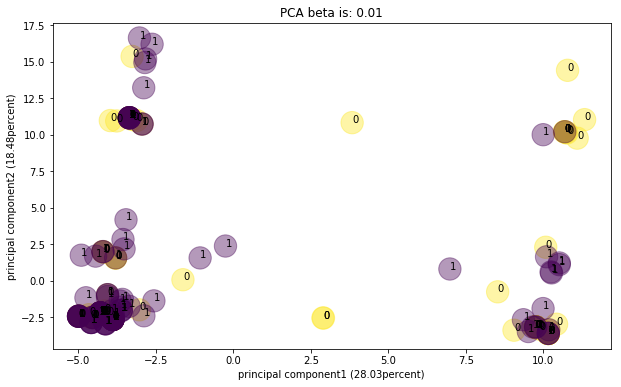

In [3]:
'''
scaler = StandardScaler()      #对X的列进行标准化
X_scaled = scaler.fit_transform(X)
'''
X_scaled = X

pca = PCA(random_state=17)
pca.fit(X_scaled)
pca_result = pca.transform(X_scaled)

#pca_result.shape

ratio = pca.explained_variance_ratio_
ratio1 = round(ratio[0]*100, 2) 
ratio2 = round(ratio[1]*100, 2)  

fig,ax=plt.subplots(figsize=(10,6))
#plt.figure(figsize=(8,6))
#全部数据
#plt.scatter(pca_result[:,0], pca_result[:,1], c=df['target'], s=2, cmap='viridis_r', alpha=0.4)
#取前10个用户
#plt.scatter(pca_result[:,0], pca_result[:,1], c=df['target'][0:4000], s=2, cmap='viridis_r', alpha=0.4)
#取前5个用户
#plt.scatter(pca_result[:,0], pca_result[:,1], c=df['target'], s=100, cmap='viridis_r', alpha=0.4)
ax.scatter(pca_result[:,0], pca_result[:,1], c=df['target'], s=500, cmap='viridis_r', alpha=0.4)

for i,txt in enumerate(y):
 ax.annotate(txt,(pca_result[i,0],pca_result[i,1]))

plt.xlabel('principal component1 ('+str(ratio1)+'percent)')
plt.ylabel('principal component2 ('+str(ratio2)+'percent)')
plt.title('PCA beta is: '+str(decay_rate))

plt.show()

Text(0.5, 1.0, 'PCA pricipal component nums for data infromantion (beta is: 0.01)')

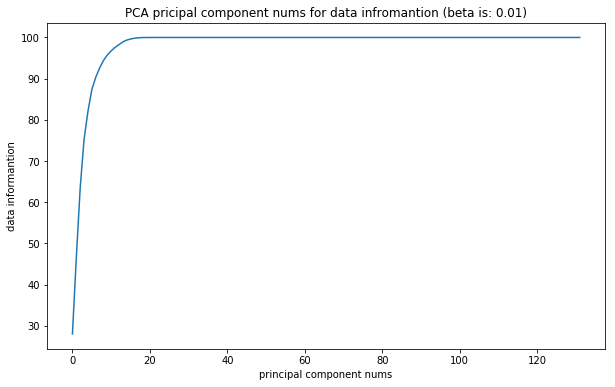

In [4]:
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel('principal component nums')
plt.ylabel('data informantion')
plt.title('PCA pricipal component nums for data infromantion ('+'beta is: '+str(decay_rate) +')')

T-SNE

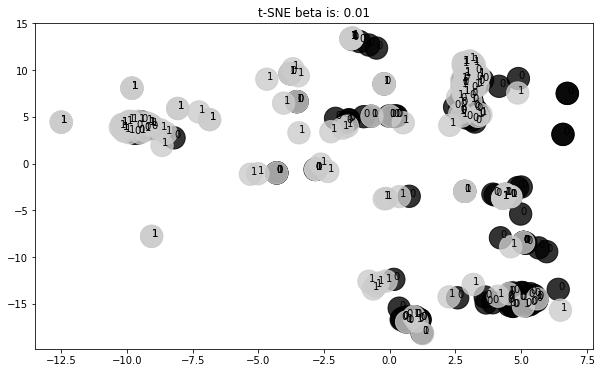

In [5]:
from sklearn.manifold import TSNE
tsne = TSNE(learning_rate=1, n_components=2, random_state=17)
tsne_representation = tsne.fit_transform(X_scaled, y=df['target'])

fig,ax=plt.subplots(figsize=(10,6))
ax.scatter(tsne_representation[:,0], tsne_representation[:,1], c=df['target'], s=500, cmap='nipy_spectral', alpha=.8)

for i,txt in enumerate(y):
 ax.annotate(txt,(tsne_representation[i,0],tsne_representation[i,1]))

plt.title('t-SNE beta is: '+str(decay_rate))

plt.show()


将样本分为训练集和测试集

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=19, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((168, 132), (72, 132), (168,), (72,))

度量选择（AUC）

In [7]:
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def custom_multi_roc_auc_score(y_true, y_pred, avg='macro'):

    lb = LabelBinarizer()
    return roc_auc_score(lb.fit_transform(y_true), y_pred, average=avg)

multi_roc_auc_scorer = make_scorer(custom_multi_roc_auc_score, needs_proba=True)

设置交叉验证，选择分类模型的参数

In [8]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
strtf_cv = StratifiedKFold(n_splits=4, random_state=17)

def plot_cv_results(grid, param='param_n_neighbors', scale='linear'):
    '''
    This function plots gridsearch results for given grid search object. It can only plot 
    results for one parameter (default parameter is C).
    '''
    plt.figure(figsize=(10,6))
    plt.plot(grid.cv_results_[param].tolist(), grid.cv_results_['mean_train_score'], label='Train Score')
    plt.fill_between(grid.cv_results_[param].tolist(), 
                     grid.cv_results_['mean_train_score'] - grid.cv_results_['std_train_score']/2, 
                     grid.cv_results_['mean_train_score'] + grid.cv_results_['std_train_score']/2, 
                     alpha=.3)
    plt.plot(grid.cv_results_[param].tolist(), grid.cv_results_['mean_test_score'], label='Validation Score')
    plt.fill_between(grid.cv_results_[param].tolist(), 
                     grid.cv_results_['mean_test_score'] - grid.cv_results_['std_test_score']/2, 
                     grid.cv_results_['mean_test_score'] + grid.cv_results_['std_test_score']/2, 
                     alpha=.3)
    plt.ylabel('ROC AUC')
    plt.xlabel(param.strip('param_'))
    plt.title('Validation Curve')
    plt.legend()
    plt.xscale(scale)
    plt.show()

KNN分类器

In [9]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_jobs=-1)

knn_params = {
    'n_neighbors': list(np.arange(1, 10)) + list(np.linspace(10, 150, 15, dtype=int))
}

knn_grid = GridSearchCV(knn_clf, param_grid=knn_params, n_jobs=-1, scoring=multi_roc_auc_scorer, cv=strtf_cv)


In [10]:
%%time
knn_grid.fit(X_train, y_train)
print('ROC AUC的最佳值:', knn_grid.best_score_)
print('最佳参数:', knn_grid.best_params_)

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 126, n_neighbors = 130

In [11]:
plot_cv_results(knn_grid, param='param_n_neighbors')

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

<Figure size 720x432 with 0 Axes>

In [ ]:
#检查模型的质量（ROC AUC）的延迟数据
#custom_multi_roc_auc_score(y_test, knn_grid.best_estimator_.predict_proba(X_test))
y_score=knn_grid.best_estimator_.predict(X_test)

In [ ]:
y_test

In [21]:
y_score

array([0, 1, 1, 1, 4, 0, 4, 4, 0, 2, 1, 1, 3, 3, 3, 0, 3, 2, 0, 1, 2, 0,
       0, 0, 0, 4, 3, 4, 3, 3, 2, 1, 1, 4, 0, 2, 3, 1, 3, 3, 0, 2, 0, 2,
       3, 4, 4, 4, 3, 2, 3, 0, 3, 0, 3, 3, 3, 2, 4, 1, 0, 0, 2, 3, 4, 0,
       4, 3, 4, 1, 4, 4, 0, 3, 2, 2, 1, 4, 2, 2, 2, 3, 0, 0, 3, 2, 2, 0,
       1, 0, 2, 2, 2, 4, 0, 4, 0, 0, 3, 3, 0, 2, 2, 0, 0, 4, 4, 0, 1, 2,
       4, 2, 1, 0, 0, 3, 2, 3, 2, 2, 1, 1, 1, 4, 0, 2, 0, 3, 4, 3, 4, 1,
       1, 0, 2, 4, 0, 2, 4, 0, 4, 4, 0, 0, 2, 3, 0, 0, 3, 2, 1, 4, 2, 4,
       3, 2, 3, 4, 3, 0, 3, 2, 2, 4, 0, 4, 2, 0, 4, 1, 3, 3, 2, 2, 2, 1,
       1, 3, 1, 3, 3, 3, 0, 3, 0, 3, 2, 2, 2, 0, 4, 4, 4, 4, 3, 0, 1, 3,
       0, 3, 2, 3, 3, 3, 2, 0, 3, 1, 2, 0, 4, 2, 4, 3, 3, 2, 2, 0, 2, 4,
       0, 4, 4, 3, 3, 4, 2, 3, 2, 2, 3, 3, 4, 0, 0, 0, 4, 0, 1, 0, 0, 4,
       3, 1, 3, 0, 2, 4, 4, 3, 0, 1, 0, 4, 4, 0, 1, 2, 0, 1, 1, 0, 4, 0,
       0, 0, 1, 2, 2, 3, 3, 3, 0, 1, 3, 0, 1, 4, 3, 2, 1, 4, 1, 3, 2, 4,
       1, 1, 2, 2, 2, 2, 4, 3, 0, 0, 3, 4, 2, 0, 0,

In [20]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

# 为每个类别计算ROC曲线和AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = 2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


'''
# 绘制所有ROC曲线(多分类)
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
'''

ValueError: multiclass format is not supported

改变了曼哈顿的距离的度量

In [18]:
knn_clf = KNeighborsClassifier(p=1, n_jobs=-1)

knn_params = {
    'n_neighbors': list(np.arange(1, 10)) + list(np.linspace(10, 150, 15, dtype=int))   
}

knn_grid_manhattan = GridSearchCV(knn_clf, param_grid=knn_params, n_jobs=-1, scoring=multi_roc_auc_scorer, cv=strtf_cv)


In [19]:
%%time
knn_grid_manhattan.fit(X_train, y_train)
print('ROC AUC的最佳值:', knn_grid_manhattan.best_score_)
print('最佳参数:', knn_grid_manhattan.best_params_)

ROC AUC的最佳值: 0.7556788340336135
最佳参数: {'n_neighbors': 150}
Wall time: 2min 33s


c:\users\jw\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


c:\users\jw\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\jw\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


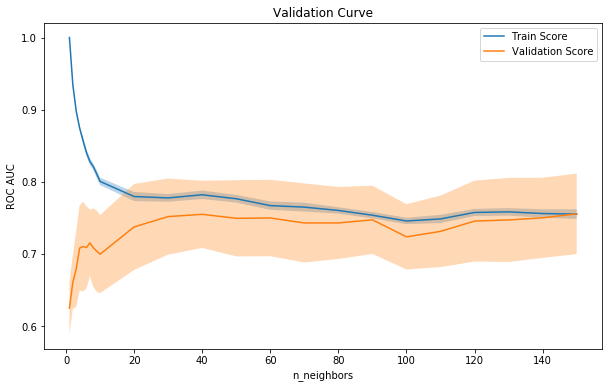

In [20]:
plot_cv_results(knn_grid_manhattan, param='param_n_neighbors')

In [16]:
#检查模型的质量（ROC AUC）的延迟数据
#custom_multi_roc_auc_score(y_test, knn_grid_manhattan.best_estimator_.predict_proba(X_test))

SVM1

In [17]:
#print(X.iloc[0].tolist())
data_index  = 400

X_predict = X.iloc[data_index].tolist()
X_predict = np.array(X_predict).reshape(1,-1)
y_predict = y[data_index]

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [19]:
#线性CVM
svm_clf = Pipeline(( ("scaler", StandardScaler()),
                     ("linear_svc", LinearSVC(C=1, loss="hinge")) ,))

svm_clf.fit( X, y )
res = svm_clf.predict( X_predict)

print('预测：',res)
print('实际：',y_predict)

c:\users\jw\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\jw\anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
c:\users\jw\anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


预测： [0]
实际： 1


c:\users\jw\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype <U22 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [20]:
#多项式分类器
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures

poly_kernel_svm_clf = Pipeline([ ( "scaler", StandardScaler()),
                                 ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=0.5))
                                ])

poly_kernel_svm_clf.fit(X,y)
res = svm_clf.predict( X_predict)

print('预测：',res)
print('实际：',y_predict)

c:\users\jw\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\jw\anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


预测： [0]
实际： 1


c:\users\jw\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype <U22 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [21]:
#高斯核SVM
rbf_kernel_svm_clf = Pipeline([
                                ("scaler", StandardScaler()), 
                                ("svm_clf", SVC(kernel="rbf", gamma=10, C=0.001))
                            ])
rbf_kernel_svm_clf.fit( X, y )
res = svm_clf.predict( X_predict)

print('预测：',res)
print('实际：',y_predict)

c:\users\jw\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\jw\anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype object were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


预测： [0]
实际： 1


c:\users\jw\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype <U22 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


SVM2

In [22]:
import numpy as np
import sklearn.model_selection as ms
import sklearn.svm as svm
import sklearn.metrics as sm
import matplotlib.pyplot as plt

# 最优超参数组合列表
params = [
        {'kernel': ['linear'], 'C': [1, 10, 100, 100]},
        {'kernel': ['poly'], 'C': [1], 'degree': [2, 3]},
        {'kernel': ['rbf'], 'C': [1, 10, 100, 100], 'gamma':[1, 0.1, 0.01, 0.001]}
        ]

model = ms.GridSearchCV(svm.SVC(probability=True), 
                        params, 
                        refit=True,
                        return_train_score=True,        # 后续版本需要指定True才有score方法  
                        cv=5)
model.fit(X, y)

# GridSearchCV的属性
print('Attrabutes:vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv')
print('cv_results_:',model.cv_results_.keys())
print('Desc:',model.cv_results_['params'][2], model.cv_results_['mean_train_score'][2], 
      model.cv_results_['mean_test_score'][2],model.cv_results_['rank_test_score'][2])
print('best_estimator_:',model.best_estimator_) 
print('best_params_:',model.best_params_) 
print('best_params_:', model.cv_results_['params'][model.best_index_])
print('best_score_:',model.best_score_)
print('scorer_:',model.scorer_)
print('n_splits_:',model.n_splits_)

c:\users\jw\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\jw\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\jw\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\jw\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The defa

Attrabutes:vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
cv_results_: dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_kernel', 'param_degree', 'param_gamma', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])
Desc: {'C': 100, 'kernel': 'linear'} 0.73125 0.65625 10
best_estimator_: SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
best_params_: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
best_params_: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
best_score_: 0.6770833333333334
scorer_: <function _passthrough_scorer

In [23]:
# 选取最优参数的模型来测试模型
model_best = model.best_estimator_
pred_test_y = model_best.predict(X_predict)
#print(sm.classification_report(test_y, pred_test_y))
print('预测：',pred_test_y)
print('实际：',y_predict)

预测： [0]
实际： 1


In [24]:
#待分类点分到k类的置信概率
probs = model_best.predict_proba(X_predict)
print(probs)

# 样本点到分割超平面的函数距离
print(model_best.decision_function(X_predict))  

[[0.69852693 0.30147307]]
[-1.0001139]


In [70]:
'''******************************绘图区：start**********************************'''
'''
plt.figure('The Best HyperParametre', facecolor='lightgray')
plt.title('The Best Hyperparametre', fontsize=14)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.tick_params(labelsize=10)

# pcolormap
l, r, h = X[:, 0].min() - 1, X[:, 0].max() + 1, 0.005
b, t, v = X[:, 1].min() - 1, X[:, 1].max() + 1, 0.005
grid_x = np.meshgrid(np.arange(l, r, h), np.arange(b, t, v))
flat_x = np.c_[grid_x[0].ravel(), grid_x[1].ravel()]
flat_y = model_best.predict(flat_x)
grid_y = flat_y.reshape(grid_x[0].shape)
plt.pcolormesh(grid_x[0], grid_x[1], grid_y, cmap='gray')

# 已知训练集的分类散点图
c0, c1 = y==0, y==1                                                             # 掩码
plt.scatter(x[c0][:, 0], x[c0][:, 1], c='b', s=30)                              # y=0的点用蓝色点表示
plt.scatter(x[c1][:, 0], x[c1][:, 1], c='r', s=30)                              # y=1的点用红色表示

# 最优模型预测的已知输入未知输出的分类散点图
C0, C1 = pred_prob_y==0, pred_prob_y==1
plt.scatter(prob_x[C0][:, 0], prob_x[C0][:, 1], c='y', s=30, marker='D')        # 预测值为0类的点用黄色表示，
plt.scatter(prob_x[C1][:, 0], prob_x[C1][:, 1], c='purple', s=30, marker='D')   # 预测值为1类的点用紫色表示，

for i in range(len(probs[C0])):
    plt.annotate(
            '{}% {}%'.format(round(probs[C0][:, 0][i],2)*100, round(probs[C0][:, 1][i],2)*100),
            xy=(prob_x[C0][:, 0][i], prob_x[C0][:, 1][i]),                      # 预测为0类的点坐标
            xytext=(12, -12),textcoords='offset points',
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=9,
            bbox={'boxstyle':'round, pad=0.6','fc':'deepskyblue', 'alpha':0.8}) # 框参数设置
for i in range(len(probs[C1])):
    plt.annotate(
            '{}% {}%'.format(round(probs[C1][:, 0][i], 2)*100, round(probs[C1][:, 1][i], 2)*100),
            xy=(prob_x[C1][:, 0][i], prob_x[C1][:, 1][i]),                      # 预测为1类的点坐标
            xytext=(12, -12),textcoords='offset points',
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=9,
            bbox={'boxstyle':'round, pad=0.6','fc':'green', 'alpha':0.4})
plt.show()
'''
'''******************************绘图区：end************************************'''

'******************************绘图区：end************************************'

In [96]:
# two-layer neural network 
# train part
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from joblib import dump

'''
#get training data
X = train_data[:,1:]
y = train_data[:,0]
'''

#neural network classifier of structure (3,2)
kf = KFold(n_splits=4) # 3-fold cross-validation
best_clf = None
best_score = 0
train_scores = []
test_scores = []
print("kfold-------")
for train_index, test_index in kf.split(X):
    # create neural network using MLPClassifer  {sgd,lbfgs, adam}
    clf = MLPClassifier(solver = 'sgd', activation = 'relu', max_iter = 100, hidden_layer_sizes = (140,128),random_state = 1)
    #X_train, X_test = X[train_index], X[test_index]
    #y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    train_scores.append(train_score)
 
    test_score = clf.score(X_test, y_test)
    test_scores.append(test_score)

    #compare score of the tree models and get the best one
    if test_score > best_score:
        best_score = test_score
        best_clf = clf
    
    #print(clf.n_outputs_)
in_sample_error = [1 - score for score in train_scores]
test_set_error = [1 - score for score in test_scores]
print("in_sample_error: ")
print(in_sample_error)
print("test_set_error: ")
print(test_set_error)

#store the classifier
if best_clf != None:
    dump(best_clf, "train_model.m")

kfold-------


c:\users\jw\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\jw\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\jw\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\jw\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


in_sample_error: 
[0.25297619047619047, 0.25297619047619047, 0.25297619047619047, 0.25297619047619047]
test_set_error: 
[0.10416666666666663, 0.10416666666666663, 0.10416666666666663, 0.10416666666666663]


In [92]:
# test part
'''
import numpy as np
from sklearn.neural_network import MLPClassifier
X_test = test_data[:,1:]
y_test = test_data[:,0]
'''
from joblib import load
clf = load("train_model.m")
y_pred = clf.predict(X_test)
np.savetxt("label_pred.txt", np.array(y_pred)) #save predict result
#print(y_pred)
test_score = clf.score(X_test, y_test)
test_error = 1 - test_score
print('test_score：%s' % test_score)
print('test_error：%s' % test_error)

test_score：0.6527777777777778
test_error：0.3472222222222222


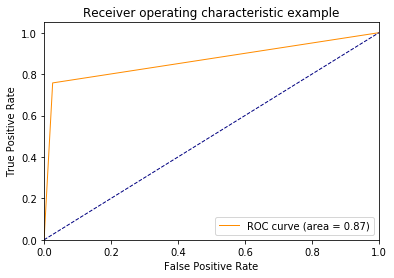

In [110]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

y_test = clf.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1, drop_intermediate=True)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [111]:
fpr

array([0.        , 0.02564103, 1.        ])

In [112]:
thresholds

array([2, 1, 0])

In [108]:
fpr.shape

(3,)